# Shape Regularization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

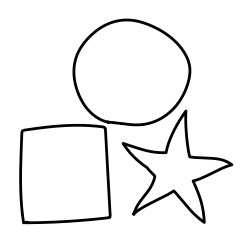

In [4]:
# We use OpenCV to detect shapes and regularize them. To do that we first convert the polylines CSV to PNG image.

def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, ax, title=None, show_axis=True):
    colours = ['black']  # Define some colors for plotting
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    if title:
        ax.set_title(title)
    if not show_axis:
        ax.axis('off')

# Read and process the CSV files
csv_path = 'isolated.csv'

output_data = read_csv_(csv_path)

# Plot the polylines and save it in a PNG
fig, ax = plt.subplots(figsize=(3, 3))
plot(output_data, ax, show_axis=False)
plt.savefig("Polylines.png", dpi=300, bbox_inches='tight', pad_inches=0)

# Optionally, show the plot if needed
plt.show()


# Now we define some functions for detecting various shapes.

In [5]:
# isCircle() - checks whether the shape detected is a circle or not by equating the area of the contour with the
# approximated radius.

def is_circle(contour, approx, circularity_tolerance=0.3, area_ratio_tolerance=0.3):
    """Check if a contour is close to a circle, allowing for a small margin of error."""
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    # Calculate circularity (4*pi*Area/Perimeter^2)
    if perimeter == 0:
        return False
    circularity = 4 * np.pi * area / (perimeter ** 2)

    # Use minimum enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(contour)
    enclosing_circle_area = np.pi * (radius ** 2)

    # Compare the contour area with the enclosing circle area
    area_ratio = area / enclosing_circle_area

    # A good circle should have a circularity close to 1 and an area ratio close to 1
    is_circular = (1 - circularity_tolerance <= circularity <= 1 + circularity_tolerance)
    is_area_close = (1 - area_ratio_tolerance <= area_ratio <= 1 + area_ratio_tolerance)

    return is_circular and is_area_close


# isStar() - checks if the shape is a star or a polygon
def is_star(approx):
    # Check if the contour has alternating points (rough heuristic)
    if len(approx) == 10:
        # Approximate angle detection for star-like features
        angles = []
        for i in range(len(approx)):
            pt1 = approx[i][0]
            pt2 = approx[(i + 2) % len(approx)][0]  # Skip adjacent points
            angle = np.arctan2(pt2[1] - pt1[1], pt2[0] - pt1[0])
            angles.append(angle)
        # Check for alternating angles
        angle_diff = np.diff(angles)
        if np.all(np.abs(angle_diff) > 0.5):  # Rough threshold to detect star pattern
            return True
    return False

# Since there might be curves in the image, we have to convert them to straight lines.
# The curve will have 3 points when seen as a contour using OpenCV.
# So if the angle between these two lines is very large (~180), we merge these points to make a straight line.

def is_nearly_straight_line(pt1, pt2, pt3, threshold=0.3):
    """Check if the angle between pt1-pt2 and pt2-pt3 is close to 180 degrees."""
    vec1 = np.array(pt1) - np.array(pt2)
    vec2 = np.array(pt3) - np.array(pt2)
    angle = np.arccos(np.clip(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)), -1.0, 1.0))
    return np.abs(angle - np.pi) < threshold

def merge_collinear_points(approx, threshold=0.3):
    """Merge nearly collinear points into a single line."""
    new_approx = []
    num_points = len(approx)

    i = 0
    while i < num_points:
        pt1 = approx[i][0]
        pt2 = approx[(i + 1) % num_points][0]
        pt3 = approx[(i + 2) % num_points][0]

        if is_nearly_straight_line(pt1, pt2, pt3, threshold):
            # Skip the middle point (pt2) if it's nearly collinear
            new_approx.append(approx[(i) % num_points])
            new_approx.append(approx[(i + 2) % num_points])
            i += 2  # Skip the next point
        else:
            new_approx.append(approx[i])
            i += 1

    return np.array(new_approx)

In [6]:
# Due to irregularity in the shapes, same shape can be detected as different contours.
# So we store the properties of each shape drawn and if a similar contour appears we ignore it as we have
# already regularized it.

def contour_properties(approx):
    """Calculate properties of the contour."""
    x, y, w, h = cv2.boundingRect(approx)
    center = (x + w // 2, y + h // 2)
    aspect_ratio = float(w) / h
    return center, aspect_ratio, w, h

def is_similar(contour1_props, contour2_props):
    """Check if two contours are similar based on their properties."""
    center1, aspect_ratio1, w1, h1 = contour1_props
    center2, aspect_ratio2, w2, h2 = contour2_props
    center_dist = np.sqrt((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2)

    aspect_ratio_similar = abs(aspect_ratio1 - aspect_ratio2) < 10
    dimension_similar = abs(w1 - w2) < 100 and abs(h1 - h2) < 100
    center_similar = center_dist < 10
    return aspect_ratio_similar and dimension_similar and center_similar

In [7]:
# Load and preprocess the image
img = cv2.imread('Polylines.png')
imgGry = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thrash = cv2.threshold(imgGry, 240, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thrash, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

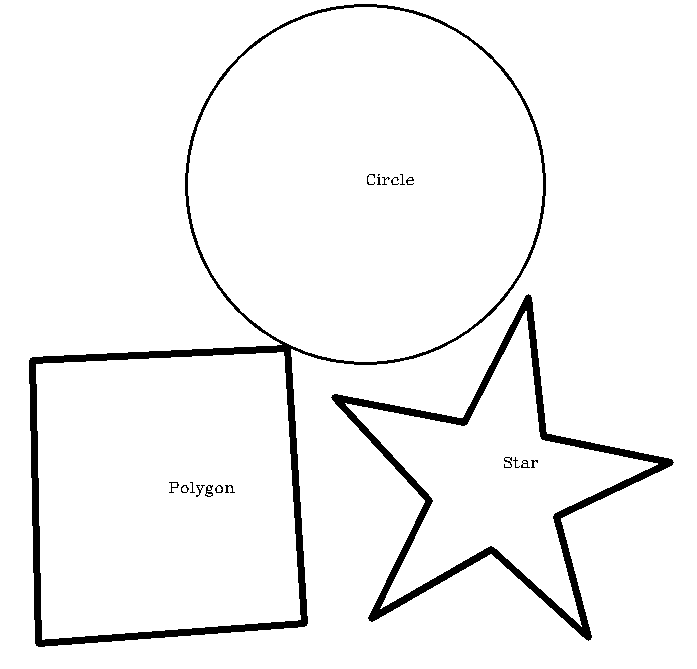

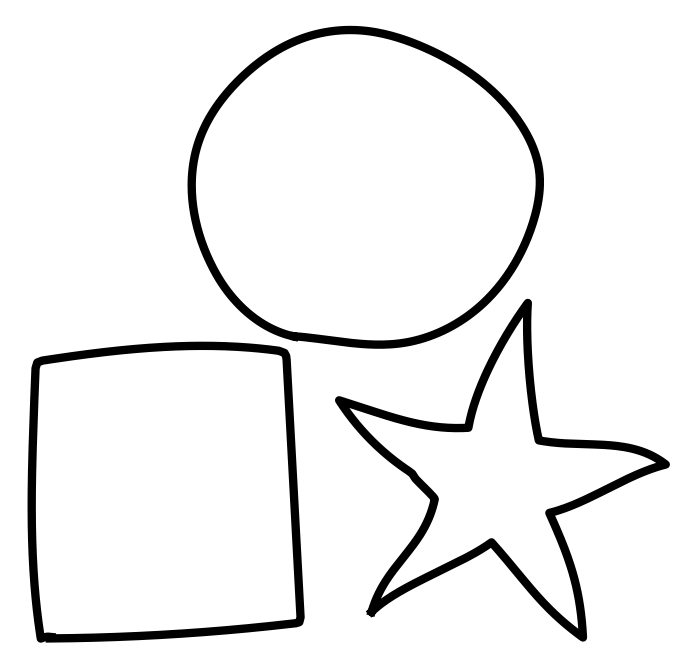

In [10]:
from google.colab.patches import cv2_imshow
output_img = np.ones_like(img) * 255   # Creating a white image where we will draw the regularized shapes.
drawn_contours_props = []  # Store the properties of drawn shapes.

first = True
for contour in contours:
    if first: # First contour is the boundary of the image so we ignore it
        first = False
        continue
    approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
    contour_props = contour_properties(approx)

    # Check for similarity with previously drawn contours
    similar_found = False
    for drawn_props in drawn_contours_props:
        if is_similar(contour_props, drawn_props):
            similar_found = True
            break

    if not similar_found:
        approx = merge_collinear_points(approx)
        num_sides = len(approx)

        if num_sides == 3:  # Triangle
            cv2.drawContours(output_img, [approx], 0, (0, 0, 0), 5)
            cv2.putText(output_img, "Triangle", tuple(contour_props[0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))

        elif num_sides == 4: # Quadrilateral
            cv2.drawContours(output_img, [approx], 0, (0, 0, 0), 5)
            x, y, w, h = cv2.boundingRect(approx)
            center = (x + w // 2, y + h // 2)
            length = w
            breadth = h
            cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 0, 0), 2)
            aspectRatio = float(w) / h
            if aspectRatio >= 0.95 and aspectRatio < 1.05:
                cv2.putText(output_img, "Square", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
            else:
                cv2.putText(output_img, "Rectangle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))

        elif num_sides <= 9: # Polygon
            cv2.drawContours(output_img, [approx], 0, (0, 0, 0), 5)
            cv2.putText(output_img, "Polygon", tuple(contour_props[0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))

        elif num_sides >= 10: # Star or Circle or Irregular shape
            if is_star(approx):
                cv2.drawContours(output_img, [approx], 0, (0, 0, 0), 5)
                cv2.putText(output_img, "Star", tuple(contour_props[0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
            else:
                if is_circle(contour, approx):
                    (x, y), radius = cv2.minEnclosingCircle(contour)
                    center = (int(x), int(y))
                    radius = int(radius)
                    cv2.circle(output_img, center, radius, (0, 0, 0), 2)
                    cv2.putText(output_img, "Circle", center, cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
                else:
                    cv2.drawContours(output_img, [contour], -1, (0, 0, 0), 2)
                    cv2.putText(output_img, "Irregular Shape", tuple(contour_props[0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))

        # Add properties of the drawn contour to the list
        drawn_contours_props.append(contour_props)

cv2_imshow(output_img)
cv2_imshow( img)
cv2.waitKey(0)
cv2.destroyAllWindows()


# Symmetries in the shapes

In [11]:
# We flip the image vertically and horizontally and then check if they are similar for symmetry.py
# We rotate the image and check symmetries for different orientations to check for diagonal or any other symmetry.


def detect_symmetries(contour, image, tolerance=0.02, angles=np.arange(0, 360, 3)):
    """Detect the number of symmetries in the contour, accounting for rotation."""
    # Create a binary mask of the contour
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    def resize_mask(m, size):
        """Resize mask to the given size."""
        return cv2.resize(m, (size[1], size[0]), interpolation=cv2.INTER_NEAREST)

    def check_symmetry(m1, m2):
        """Check if two masks are similar within a given tolerance."""
        if m1.shape != m2.shape:
            m2 = resize_mask(m2, m1.shape)
        return np.mean(np.abs(m1 - m2)) < tolerance * 255

    symmetries = 0
    mask_h, mask_w = mask.shape

    # Horizontal and Vertical Symmetry
    flip_h = cv2.flip(mask, 0)
    flip_v = cv2.flip(mask, 1)

    if check_symmetry(mask, flip_h):
        symmetries += 1
    if check_symmetry(mask, flip_v):
        symmetries += 1

    # Diagonal Symmetries
    flip_d1 = cv2.transpose(mask)
    flip_d1 = cv2.flip(flip_d1, 1)
    flip_d2 = cv2.transpose(mask)
    flip_d2 = cv2.flip(flip_d2, 0)

    if check_symmetry(mask, flip_d1):
        symmetries += 1
    if check_symmetry(mask, flip_d2):
        symmetries += 1

    # Check Rotations
    for angle in angles:
        M = cv2.getRotationMatrix2D((mask_w / 2, mask_h / 2), angle, 1)
        rotated_mask = cv2.warpAffine(mask, M, (mask_w, mask_h), flags=cv2.INTER_NEAREST)

        if check_symmetry(mask, rotated_mask):
            symmetries += 1

    return symmetries

In [12]:
# Load and preprocess the image
img = cv2.imread('Polylines.png')
imgGry = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thrash = cv2.threshold(imgGry, 240, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thrash, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

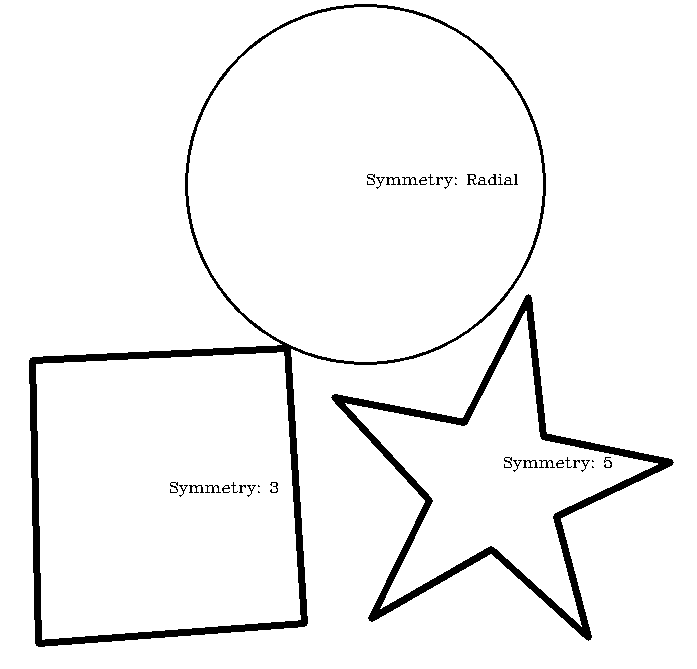

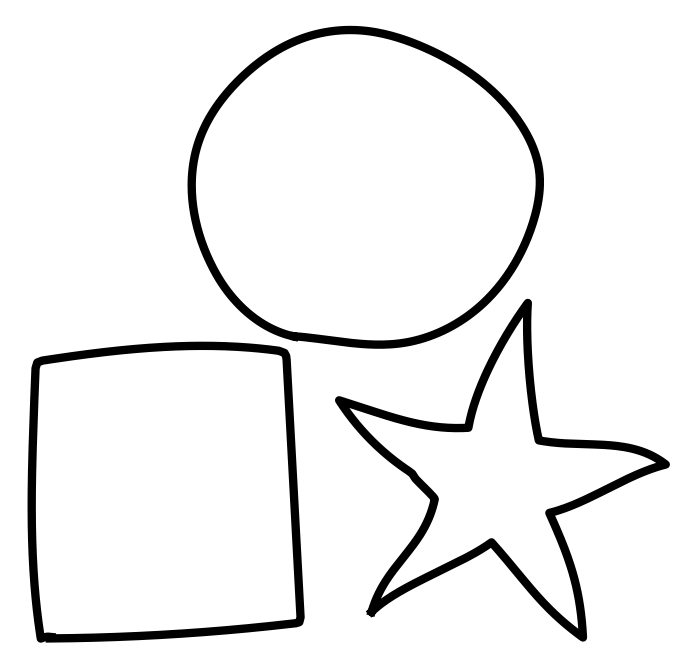

In [15]:
output_img = np.ones_like(img) * 255
drawn_contours_props = []

first = True
for contour in contours:
    if first:
        first = False
        continue
    approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
    contour_props = contour_properties(approx)

    similar_found = False
    for drawn_props in drawn_contours_props:
        if is_similar(contour_props, drawn_props):
            similar_found = True
            break

    if not similar_found:
        approx = merge_collinear_points(approx)
        num_sides = len(approx)

        if num_sides == 3:
            cv2.drawContours(output_img, [approx], 0, (0, 0, 0), 5)
            symmetries = detect_symmetries(approx, img)
            cv2.putText(output_img, f"Symmetry: {symmetries}", tuple(contour_props[0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))

        elif num_sides == 4:
            cv2.drawContours(output_img, [approx], 0, (0, 0, 0), 5)
            x, y, w, h = cv2.boundingRect(approx)
            center = (x + w // 2, y + h // 2)
            length = w
            breadth = h
            cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 0, 0), 2)
            aspectRatio = float(w) / h
            if aspectRatio >= 0.95 and aspectRatio < 1.05:
                cv2.putText(output_img, f"Symmetry: 4", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
            else:
                cv2.putText(output_img, f"Symmetry: 2", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))

        elif num_sides <= 9:
            cv2.drawContours(output_img, [approx], 0, (0, 0, 0), 5)
            # cv2.putText(output_img, "Polygon", tuple(contour_props[0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
            symmetries = detect_symmetries(approx, img)
            cv2.putText(output_img, f"Symmetry: {symmetries}", tuple(contour_props[0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))

        elif num_sides >= 10:
            if is_star(approx):
                cv2.drawContours(output_img, [approx], 0, (0, 0, 0), 5)
                symmetries = detect_symmetries(approx, img)
                cv2.putText(output_img, f"Symmetry: {symmetries}", tuple(contour_props[0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))

            elif is_circle(contour, approx):
                    (x, y), radius = cv2.minEnclosingCircle(contour)
                    center = (int(x), int(y))
                    radius = int(radius)
                    cv2.circle(output_img, center, radius, (0, 0, 0), 2)
                    # cv2.putText(output_img, "Circle", center, cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
                    cv2.putText(output_img, f"Symmetry: Radial", center, cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))

            else:
                cv2.drawContours(output_img, [contour], -1, (0, 0, 0), 2)
                symmetries = detect_symmetries(approx, img)
                # cv2.putText(output_img, f"Symmetry: {symmetries}", tuple(contour_props[0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))

        drawn_contours_props.append(contour_props)

cv2_imshow(output_img)
cv2_imshow( img)
cv2.waitKey(0)
cv2.destroyAllWindows()